In [1]:
# to start, let's try to implement a REINFORCE algorithm (policy gradient)
# we only need some sort of featurizer, 
# a policy graph network, 
# and the reinforcement learning loop

In [2]:
# # note: code borrowed from gaeun
import os 
import yaml

yamls_path = "/project/liulab/gkim/antigen_prediction/eval_boltz_on_sabdab/all_yaml_outdir"
pdbs_path = "/project/liulab/gkim/antigen_prediction/data/renumbered_sabdab_pdb_files/pdb_files"

def get_chain_info_from_pdb(pdb_path, yaml_path):
    """Get chain information from YAML file."""    
    if not os.path.exists(pdb_path):
        return None, None, None, None, None
    
    if not os.path.exists(yaml_path):
        print(f"No YAML file found at {yaml_path}")
        return None, None, None, None, None
    
    try:
        with open(yaml_path, 'r') as f:
            yaml_data = yaml.safe_load(f)
        
        # Extract chain IDs and sequences from YAML data
        # Assume the first sequence is heavy and the second sequence is light
        # UNLESS there are more than 2 sequences
        h_chain = None
        l_chain = None
        h_seq_yaml = None
        l_seq_yaml = None

        # Look for sequences in the YAML data
        if 'sequences' in yaml_data and isinstance(yaml_data['sequences'], list):
            sequences = yaml_data['sequences']
            if len(sequences) == 2:
                h_chain = sequences[0]['protein']['id']  # First sequence is heavy
                l_chain = sequences[1]['protein']['id']  # Second sequence is light
                h_seq_yaml = sequences[0]['protein']['sequence']
                l_seq_yaml = sequences[1]['protein']['sequence']
            elif len(sequences) > 2:
                # first sequence is antigen (for multimer predictions)
                h_chain = sequences[1]['protein']['id']  # Second sequence is heavy
                l_chain = sequences[2]['protein']['id']  # Third sequence is light
                h_seq_yaml = sequences[1]['protein']['sequence']
                l_seq_yaml = sequences[2]['protein']['sequence']
        
        if 'antigen' in yaml_data and isinstance(yaml_data['antigen'], list):
            antigen = yaml_data['antigen'][0]['protein']['sequence']
        else:
            antigen = None
        
        return h_chain, l_chain, h_seq_yaml, l_seq_yaml, antigen
        
    except Exception as e:
        print(f"Error reading YAML file for {yaml_path}: {e}")
        return None, None, None, None, None

In [3]:
import pandas as pd
sd_pd = pd.read_csv("sabdab_summary_all.tsv", sep="\t")

In [4]:
from Bio.PDB.Polypeptide import three_to_index

def featurizer(heavy_chain, ag_chain, device='cpu'):
    # https://towardsdatascience.com/graph-convolutional-networks-introduction-to-gnns-24b3f60d6c95/
    # node feature matrix with shape (number of nodes, number of features)
    # graph connectivity (how the nodes are connected) with shape (2, number of directed edges)
    # node ground-truth labels. In this problem, every node is assigned to one class (group)

    # # construct the distance matrix
    heavy_coords = np.array([res['CA'].coord for res in heavy_chain if 'CA' in res])
    antigen_coords = np.array([res['CA'].coord for res in ag_chain if 'CA' in res])
    antigen_residues = np.array([int(res.id[1]) for res in ag_chain if 'CA' in res])
    
    dist_matrix = np.linalg.norm(
        heavy_coords[:, np.newaxis, :] - antigen_coords[np.newaxis, :, :],
        axis=-1
    )
    # https://numpy.org/devdocs/reference/generated/numpy.argpartition.html
    # only sort the bottom k
    bottom_k = np.argpartition(dist_matrix.flatten(), k)[:k]
    # flatten and unravel :)
    bottom_k_indices = np.unravel_index(bottom_k, dist_matrix.shape)

    residues = bottom_k_indices
    
    def matrix_idx_to_resnum(chain, matrix_idx_list):
        ca_residues = [res for res in chain if 'CA' in res]
        return [int(ca_residues[i].id[1]) for i in matrix_idx_list]

    # Convert matrix indices → PDB residue numbers
    heavy_residues = matrix_idx_to_resnum(heavy_chain, list(dict.fromkeys(residues[0])))
    ag_residues    = matrix_idx_to_resnum(ag_chain, list(dict.fromkeys(residues[1])))
    
    # matrix indices (0..N-1) → PDB residue numbers
    heavy_id_map = [int(res.id[1]) for res in heavy_chain if 'CA' in res]
    ag_id_map    = [int(res.id[1]) for res in ag_chain if 'CA' in res]

    # pdb residue numbers of the heavy and antigen residues
    heavy_residues = [heavy_id_map[item.item()] for item in list(dict.fromkeys(residues[0]))]
    ag_residues = [ag_id_map[item.item()] for item in list(dict.fromkeys(residues[1]))]

    node_features = torch.zeros(len(heavy_residues + ag_residues), 2, device=device) # chain, residue_id
    
    heavy_idx_to_node_idx = {res_idx: i for i, res_idx in enumerate(heavy_residues)}
    ag_idx_to_node_idx = {res_idx: i + len(heavy_residues) for i, res_idx in enumerate(ag_residues)}

    # heavy chains are "0" and antigen chains are "1"
    for i, res_idx in enumerate(heavy_residues + ag_residues):
        if i < len(heavy_residues):
            res_idx = heavy_id_map[i]
            node_features[i][0] = 0
            node_features[i][1] = three_to_index(heavy_chain[res_idx].get_resname())
        else:
            res_idx = ag_id_map[i - len(heavy_residues)]
            node_features[i][0] = 1
            node_features[i][1] = three_to_index(ag_chain[res_idx].get_resname())

    # node_features = node_features.T
    
    hc_nodes = torch.tensor([heavy_idx_to_node_idx[matrix_idx_to_resnum(heavy_chain, [id.item()])[0]] 
                             for id in residues[0]], device=device)
    ag_nodes = torch.tensor([ag_idx_to_node_idx[matrix_idx_to_resnum(ag_chain, [id.item()])[0]] 
                             for id in residues[1]], device=device)
    # print(torch.vstack((hc_nodes, ag_nodes)).shape)
    # print(torch.vstack((hc_nodes, ag_nodes)).T.shape)
    # raise Exception
    edge_connections = torch.vstack((hc_nodes, ag_nodes))
    
    num_edges = edge_connections.T.shape[0]
    edge_features = torch.zeros(num_edges, 1, device=device)
    for j, (a, b) in enumerate(zip(residues[0], residues[1])):
        edge_features[j] = dist_matrix[a, b].item()
    # edge_features = edge_features
        
    return node_features, edge_connections, edge_features

In [5]:
i = 0
k = 12

from Bio.PDB import PDBList, PDBParser, Select, PDBIO
import numpy as np
from tqdm import tqdm 
import torch

parser = PDBParser(QUIET=True)

heavy_chains, antigen_chains = [], []
for yaml_file in tqdm(os.listdir(yamls_path)[:10], desc="Processing YAML files"):
    yaml_path = os.path.join(yamls_path, yaml_file)
    name = yaml_file.split('.')[0]
    pdb_file = name + '.pdb'
    pdb_path = os.path.join(pdbs_path, pdb_file)
    # we'll use Gauen's function because it already maps from the name to the pdb that is already downloaded on the server...
    h, l, _, _, _ = get_chain_info_from_pdb(pdb_path, yaml_path)
    row = sd_pd[(sd_pd["pdb"] == name) & (sd_pd["Hchain"] == h) & (sd_pd["Lchain"] == l)]
    if row.empty:
        continue
    ag = row["antigen_chain"].values[0] # this gives us the antigen chain alone!
    structure = parser.get_structure(name, pdb_path)
    if ag not in [chain.id for chain in structure[0]]:
        continue

    # # make a distance matrix
    heavy_Cas = []
    
    # # convert this into accessing entries in a generator?
    heavy_chain = structure[0][h]
    antigen_chain = structure[0][ag]
    heavy_chains.append(heavy_chain)
    antigen_chains.append(antigen_chain)

    # node_features, edge_connections, edge_features = featurizer(heavy_chain, antigen_chain)
print(heavy_chains, antigen_chains)

Processing YAML files: 100%|██████████| 10/10 [00:00<00:00, 22.00it/s]

[<Chain id=H>, <Chain id=F>, <Chain id=H>, <Chain id=C>] [<Chain id=C>, <Chain id=D>, <Chain id=A>, <Chain id=A>]


In [6]:
# reference: https://medium.com/@volzhinnv/graph-convolutional-networks-gcn-all-you-need-to-know-code-implementation-fdfcde657b5c

from torch_geometric.nn import GCNConv
from torch_geometric.nn import GINEConv
from torch_geometric.nn import Sequential
from torch_geometric.nn import global_add_pool
import torch.nn.functional as F
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GINEConv.html?utm_source=chatgpt.com
# class GCN(nn.Module):
#     def __init__(self, num_node_features, hidden_dim, output_dimension):
#         super(GCN, self).__init__()
#         edge_mlp = nn.Sequential(
#             nn.Linear(1, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, hidden_dim)
#         )
#         self.conv1 = GINEConv(nn.Linear(num_node_features, hidden_dim), edge_mlp)
#         self.conv2 = GINEConv(nn.Linear(hidden_dim, hidden_dim), edge_mlp)
#         self.conv3 = GINEConv(nn.Linear(hidden_dim, hidden_dim), edge_mlp)
#         self.readout = nn.Linear(hidden_dim, output_dimension)

#     def forward(self, x, edge_index, batch):
#         x = self.conv1(x, edge_index, edge_attr)
#         x = F.relu(x)
#         x = self.conv2(x, edge_index, edge_attr)
#         x = F.relu(x)
#         x = self.conv3(x, edge_index, edge_attr)
#         x = global_add_pool(x, batch)
#         x = self.readout(x)
#         return x

/scratch/sa4139/rl_ag_dock/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# output_dim = 6 
# model = GCN(num_node_features=node_features.size(1),
#             hidden_dim=128,
#             output_dimension=output_dim).to(device)

In [14]:
import gymnasium as gym
from gymnasium.spaces import Box
from gymnasium.utils import seeding
from torch_geometric.data import Data
from numpy import pi
from Bio.PDB.vectors import rotaxis2m
from Bio.PDB.vectors import Vector
import random 

class DockingEnv(gym.Env):
    # metadata = {'render.modes': ['human']}

    def __init__(self, heavy_chains, antigen_chains, featurizer, k=12, device='cpu'):
        self.heavy_chains = heavy_chains
        self.antigen_chains = antigen_chains
        self.featurizer = featurizer
        self.device = device
        self.action_space = Box(low = np.array([0, 0, 0, 0, 0, 0]), high = np.array([10, 10, 10, 2*np.pi, 2*np.pi, 2*np.pi], dtype=np.float32))
        self.observation_space = None
        # store the starting coordinates of every antigen atom in a fixed order
        self.current_step = 0
        
    def step(self, action):
        self.current_step += 1
        node_features, edge_index, edge_attr = self.featurizer(self.heavy_chain, self.antigen_chain, device=self.device)
        state = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr) # store this as a Data type object!
        # buffer.states.append(state)
        trans = action[0:3]
        rot = action[3:]
        # print(action)
        # multiply the rotation matrices wrt each of the directions
        rotm = rotaxis2m(rot[0], Vector(1, 0, 0)) @ rotaxis2m(rot[1], Vector(0, 1, 0)) @ rotaxis2m(rot[2], Vector(0, 0, 1))
        for atom in self.antigen_chain.get_atoms():
            first_atom_coord = atom.coord
            # going into a coordinate object, convert everything to numpy
            atom.coord = rotm @ atom.coord + np.array(trans)
            node_features, edge_index, edge_attr = self.featurizer(self.heavy_chain, self.antigen_chain, device=self.device)
        next_state = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr) 
        next_reward = self._compute_reward()
        # print(next_reward)
        return next_state, next_reward, next_reward > -100 or self.current_step > 20, None
        
    def reset(self):
        complex_i = random.randrange(len(self.antigen_chains))
        print(complex_i)
        self.antigen_chain = self.antigen_chains[complex_i]
        self.heavy_chain = self.heavy_chains[complex_i]
        self.starting_ag_coords = [atom.coord.copy() for atom in self.antigen_chain.get_atoms()]
        self.current_step = 0
        # reset antigen atoms to their stored starting positions, then apply a translation
        for atom, start_coord in zip(self.antigen_chain.get_atoms(), self.starting_ag_coords):
            atom.coord = start_coord + np.array([-10, 0, 0])
        return self._get_state()

    def _get_state(self):
        node_features, edge_index, edge_attr = self.featurizer(self.heavy_chain, self.antigen_chain, device=self.device)
        # print(edge_index.shape, edge_attr.shape)
        return Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)

    def _compute_reward(self):
        node_features, edge_index, edge_attr = self.featurizer(self.heavy_chain, self.antigen_chain, device=self.device)
        reward = -edge_attr.mean().item()
        # print(reward)
        return reward

In [15]:
class RolloutBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.dones = []

    def store_transition(self, state, action, logprob, reward, done, state_value):
        self.states.append(state)
        self.actions.append(action)
        self.logprobs.append(logprob)
        self.rewards.append(reward)
        self.state_values.append(state_value)
        self.dones.append(done)
    
    def clear(self):
        self.states.clear()
        self.actions.clear()
        self.logprobs.clear()
        self.rewards.clear()
        self.state_values.clear()
        self.dones.clear()

In [16]:
import torch
import torch.nn as nn
from torch_geometric.nn import GINEConv, global_add_pool
from torch.distributions import Normal

class GNNActorCritic(nn.Module):
    def __init__(self, node_feature_dim, hidden_dim, action_dim, continuous_action=True):
        super().__init__()
        self.continuous_action = continuous_action
        # print(hidden_dim)

        nn1 = nn.Sequential(nn.Linear(node_feature_dim, hidden_dim), nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim))
        self.conv1 = GINEConv(nn1, edge_dim=1)
        nn2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim))
        self.conv2 = GINEConv(nn2, edge_dim=1)

        self.feature_extractor = nn.ModuleList([self.conv1, self.conv2])

        self.actor_head = nn.Linear(hidden_dim, action_dim)
        self.critic_head = nn.Linear(hidden_dim, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        x = self.conv1(x, edge_index, edge_attr)
        x = self.conv2(x, edge_index, edge_attr)
        x = global_add_pool(x, batch)  # Graph-level embedding
        return self.actor_head(x), self.critic_head(x)

    def evaluate_actions(self, x, edge_index, edge_attr, batch, actions):
        action_mean, state_values = self.forward(x, edge_index, edge_attr, batch)
        action_mean = torch.clamp(action_mean, -1e3, 1e3)
        dist = torch.distributions.Normal(action_mean, 0.1)
        logprobs = dist.log_prob(actions).sum(-1)
        entropy = dist.entropy().sum(-1)
        return state_values.squeeze(), logprobs, entropy

    def select_action(self, state):
        batch = torch.zeros(state.x.size(0), dtype=torch.long, device=state.x.device)
        action_mean, state = self.forward(state.x, state.edge_index, state.edge_attr, batch)
        action_mean = torch.clamp(action_mean, -1e3, 1e3)
        dist = Normal(action_mean, 0.1)
        action = dist.sample().squeeze()
        logprob = dist.log_prob(action).sum(-1)
        return action, logprob
                     

In [17]:
# https://github.com/saqib1707/RL-PPO-PyTorch
class PPOAgent:
    def __init__(
            self, 
            obs_dim, 
            action_dim, 
            hidden_dim, 
            lr_actor, 
            lr_critic, 
            continuous_action_space=False, 
            num_epochs=10, 
            eps_clip=0.2, 
            action_std_init=0.6, 
            gamma=0.99,
            entropy_coef=0.01,
            value_loss_coef=0.5,
            batch_size=64,
            max_grad_norm=0.5,
            device='cpu'
        ):
        self.gamma = gamma
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.eps_clip = eps_clip
        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm

        self.obs_dim = obs_dim
        self.action_dim = action_dim
        self.action_std_init = action_std_init
        self.continuous_action_space = continuous_action_space
        self.device = device

        self.policy = GNNActorCritic(
            node_feature_dim=obs_dim,  # this is the node feature size
            hidden_dim=hidden_dim,
            action_dim=action_dim,
            continuous_action=True  # we want continuous 6D actions
        ).to(device)
        
        self.optimizer = torch.optim.Adam([
            {'params': self.policy.feature_extractor.parameters()},
            {'params': self.policy.actor_head.parameters(), 'lr': lr_actor},
            {'params': self.policy.critic_head.parameters(), 'lr': lr_critic}
        ])

        self.buffer = RolloutBuffer()
        self.mse_loss = nn.MSELoss()  # Initialize MSE loss


    def compute_returns(self):
        returns = []
        discounted_reward = 0

        for reward, done in zip(reversed(self.buffer.rewards), reversed(self.buffer.dones)):
            if done:
                discounted_reward = 0
            discounted_reward = reward + self.gamma * discounted_reward
            returns.insert(0, discounted_reward)

        returns = np.array(returns, dtype=np.float32)
        returns = torch.flatten(torch.from_numpy(returns).float()).to(self.device)
        return returns


    def update_policy(self):
        # Skip update if buffer is empty
        if len(self.buffer.rewards) == 0:
            self.buffer.clear()
            return
            
        # print(len(self.buffer.rewards))
        rewards_to_go = self.compute_returns()
        # print(len(rewards_to_go))

        # Handle Data objects - batch them instead of converting to numpy
        from torch_geometric.data import Batch
        states_list = [s.to(self.device) for s in self.buffer.states]
        
        # Convert actions, logprobs, state_vals to tensors on device
        actions_list = []
        for action in self.buffer.actions:
            if isinstance(action, torch.Tensor):
                actions_list.append(action.cpu().numpy() if action.is_cuda else action.numpy())
            else:
                actions_list.append(action)
        actions = torch.from_numpy(np.array(actions_list, dtype=np.float32)).to(self.device)
        
        logprobs_list = []
        for logprob in self.buffer.logprobs:
            if isinstance(logprob, torch.Tensor):
                logprobs_list.append(logprob.cpu().item() if logprob.is_cuda else logprob.item())
            else:
                logprobs_list.append(logprob)
        old_logprobs = torch.from_numpy(np.array(logprobs_list, dtype=np.float32)).to(self.device)
        
        state_vals_list = []
        for sv in self.buffer.state_values:
            if isinstance(sv, torch.Tensor):
                state_vals_list.append(sv.cpu().item() if sv.is_cuda else sv.item())
            else:
                state_vals_list.append(sv)
        state_vals = torch.from_numpy(np.array(state_vals_list, dtype=np.float32)).to(self.device)

        # print('stage-0:', rewards_to_go.shape, state_vals.shape)
        # print('stage-1:', rewards_to_go.device, state_vals.device)
        advantages = rewards_to_go - state_vals
        
        if len(advantages) == 1:
            advantages = advantages - advantages.mean()
        else:
            adv_std = advantages.std()
            if adv_std > 1e-8:
                advantages = (advantages - advantages.mean()) / adv_std
            else:
                advantages = advantages - advantages.mean()
        advantages = torch.clamp(advantages, min=-10.0, max=10.0)

        # print(states.shape, actions.shape, old_logprobs.shape, state_vals.shape, advantages.shape, rewards_to_go.shape)

        for _ in range(self.num_epochs):
            # generate random indices for minibatch
            indices = np.random.permutation(len(self.buffer.states))

            for start_idx in range(0, len(self.buffer.states), self.batch_size):
                end_idx = start_idx + self.batch_size
                batch_indices = indices[start_idx:end_idx]

                # Batch Data objects
                batch_states = Batch.from_data_list([states_list[i] for i in batch_indices])
                batch_actions = actions[batch_indices]
                batch_old_logprobs = old_logprobs[batch_indices]
                batch_advantages = advantages[batch_indices]
                batch_rewards_to_go = rewards_to_go[batch_indices]
                
                # evaluate old actions and values
                state_values, logprobs, dist_entropy = self.policy.evaluate_actions(
                    batch_states.x, batch_states.edge_index, batch_states.edge_attr, batch_states.batch, batch_actions
                )
                # print(logprobs.shape, batch_old_logprobs.shape)

                logprob_diff = torch.clamp(logprobs - batch_old_logprobs.squeeze(-1), min=-10, max=10)
                ratios = torch.exp(logprob_diff)

                surr1 = ratios * batch_advantages
                surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * batch_advantages

                actor_loss = -torch.min(surr1, surr2).mean()
                state_values_flat = state_values.view(-1)
                critic_loss = 0.5 * self.mse_loss(state_values_flat, batch_rewards_to_go)
                loss = actor_loss + self.value_loss_coef * critic_loss - self.entropy_coef * dist_entropy.mean()

                self.optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.policy.parameters(), self.max_grad_norm)
                self.optimizer.step()
        
        self.buffer.clear()

In [18]:
# code taken from https://github.com/saqib1707/RL-PPO-PyTorch/blob/main/src/model.py
import time
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torch.distributions import MultivariateNormal
from torch.optim import Adam
# import gym


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")


class FeedForwardNN(nn.Module):
    def __init__(self, inp_dim, out_dim, hidden_size=64):
        super(FeedForwardNN, self).__init__()

        self.layer1 = nn.Linear(inp_dim, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, out_dim)
        self.relu = nn.ReLU()

    
    def forward(self, obs):
        # convert observation to tensor if it's a numpy array
        if isinstance(obs, np.ndarray):
            obs = torch.tensor(obs, dtype=torch.float)

        x = self.relu(self.layer1(obs))
        x = self.relu(self.layer2(x))
        out = self.layer3(x)
        return out


class ProximalPolicyOptimization:
    def __init__(self, env, seed=43, lr=1e-3):
        assert type(env.observation_space) == Box, "This example only works for envs with continuous state spaces."
        assert type(env.action_space) == Box, "This example only works for envs with continuous action spaces."
        self._set_seed(seed)

        # extract environment information
        self.env = env
        self.obs_dim = env.observation_space.shape[0]    # = ns
        self.act_dim = env.action_space.shape[0]    # = na
        print(f"Observation Dimension: {self.obs_dim} | Action Dimension: {self.act_dim}")

        # initialize actor and critic networks
        self.actor = FeedForwardNN(inp_dim=self.obs_dim, out_dim=self.act_dim)
        self.critic = FeedForwardNN(inp_dim=self.obs_dim, out_dim=1)

        self.actor_optimizer = Adam(self.actor.parameters(), lr=lr, betas=(0.9, 0.999))
        self.critic_optimizer = Adam(self.critic.parameters(), lr=lr, betas=(0.9, 0.999))

        # initialize action covariance matrix for exploration
        self.act_cov = torch.diag(torch.full(size=(self.act_dim,), fill_value=0.5))    # (na,na)
        # print(self.action_cov_mat)

        # initialize logger
        self.logger = {
            'delta_t': time.time_ns(),
            't_so_far': 0,
            'i_so_far': 0,
            'batch_lens': [],
            'batch_rewards': [],
            'actor_losses': [],
        }


    def learn(self, total_timesteps, timesteps_per_batch, max_eps_len, num_updates_per_itr, clip_thresh=0.2, save_every=1000, gamma=0.9):
        t_so_far = 0    # timesteps simulated so far
        i_so_far = 0

        while t_so_far < total_timesteps:
            # roll out multiple trajectories
            batch_obs, batch_actions, batch_logprobs, batch_reward_to_go, batch_eps_lens = self.collect_rollouts(
                timesteps_per_batch, 
                max_eps_len, 
                gamma
            )
            print("stage-1:", batch_obs.shape, batch_actions.shape, batch_logprobs.shape, batch_reward_to_go.shape)

            # calculate how many timesteps collected in this batch
            t_so_far += np.sum(batch_eps_lens)
            i_so_far += 1

            # logging timesteps and iterations so far
            self.logger['t_so_far'] = t_so_far
            self.logger['i_so_far'] = i_so_far

            # calculate value function V_{phi, k} using critic model
            V, _ = self.evaluate(batch_obs, batch_actions)

            # calculate advantage function A_k
            A_k = batch_reward_to_go - V.detach()

            # normalize advantage function
            A_k = (A_k - A_k.mean()) / (A_k.std() + 1e-10)

            for _ in range(num_updates_per_itr):
                # calculate pi_theta(at | st)
                curr_V, curr_logprobs = self.evaluate(batch_obs, batch_actions)

                # calcuate ratios
                ratios = torch.exp(curr_logprobs - batch_logprobs)

                # calcuate surrogate losses
                surr1 = ratios * A_k

                # clips ratio to make sure we are not stepping too far in any direction during gradient ascent
                surr2 = torch.clamp(ratios, 1 - clip_thresh, 1 + clip_thresh) * A_k

                # calculate actor and critic losses
                actor_loss = -torch.min(surr1, surr2).mean()
                critic_loss = nn.MSELoss()(curr_V, batch_reward_to_go)

                # calculate gradients and backpropagate for actor network
                self.actor_optimizer.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.actor_optimizer.step()

                # calculate gradients and backpropagate for critic network
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                self.logger['actor_losses'].append(actor_loss.detach())
            
            # print a summary of the training so far
            self._log_summary(total_timesteps)

            if i_so_far % save_every == 0:
                torch.save(self.actor.state_dict(), './checkpoints/ppo_actor.pth')
                torch.save(self.critic.state_dict(), './checkpoints/ppo_critic.pth')


    def evaluate(self, batch_obs, batch_actions):
        value = self.critic(batch_obs).squeeze()
        # print(value.shape)

        # calculate the log probabilities of batch actions using most recent actor network
        mean = self.actor(batch_obs)
        # print("Stage-2", mean.shape, self.action_cov_mat.shape, batch_obs.shape, batch_actions.shape)
        dist = MultivariateNormal(mean, self.act_cov)
        # print("This would be printed", dist)
        logprob = dist.log_prob(batch_actions)
        # print("This would not be printed", dist)
        return value, logprob


    def collect_rollouts(self, max_timesteps, max_eps_len, gamma):
        observations = []
        actions = []
        logprobs = []
        rewards = []
        eps_lens = []

        t = 0
        while t < max_timesteps:
            # reset environment and get initial observation
            obs, _ = self.env.reset()
            done = False
            # print("Stage-2 after reset:", obs)

            eps_rewards = []
            for step in range(max_eps_len):
                action, logprob = self.select_action(obs)
                next_obs, reward, done, _, _ = self.env.step(action)
                t += 1

                # collect observation, action, log probabilities and reward
                observations.append(obs)
                actions.append(action)
                logprobs.append(logprob)
                eps_rewards.append(reward)

                obs = next_obs
                if done:
                    break
            
            # collect episode length and rewards
            rewards.append(eps_rewards)
            eps_lens.append(step+1)

        # reshape numpy data as tensors
        observations = torch.from_numpy(np.array(observations, dtype=np.float32))    # [max_timesteps, ns]
        actions = torch.from_numpy(np.array(actions, dtype=np.float32))    # [max_timesteps, na]
        actions = actions.unsqueeze(1)
        logprobs = torch.from_numpy(np.array(logprobs, dtype=np.float32))    # [max_timesteps]
        rewards_to_go = self.compute_reward_to_go(rewards, gamma)
        # print("Stage-0:", np.array(batch_rewards).shape, batch_reward_to_go.shape)
        # batch_episode_lengths = torch.tensor(batch_episode_lengths, dtype=torch.float32)

        # log the episodic rewards and lengths
        self.logger['batch_rewards'] = rewards
        self.logger['batch_lengths'] = eps_lens
        return observations, actions, logprobs, rewards_to_go, eps_lens


    def compute_reward_to_go(self, rewards, gamma):
        """
        Compute the discounted reward-to-go for each timestep in each episode
        Args:
            rewards: list of lists, where each inner list contains rewards for an episode
            gamma: discount  for future rewards
        Returns:
            rewards_to_go: list of reward-to-go for each timestep in each episode
        """
        rewards_to_go = []

        # iterate through each episodic rewards
        for eps_rewards in rewards:
            eps_rewards_to_go = []
            reward_sum = 0

            for r in reversed(eps_rewards):
                reward_sum = r + gamma * reward_sum    # discounted reward
                eps_rewards_to_go.append(reward_sum)

            eps_rewards_to_go = eps_rewards_to_go[::-1]
            rewards_to_go.append(eps_rewards_to_go)

        # convert reward-to-go into tensor
        rewards_to_go = np.array(rewards_to_go, dtype=np.float32)
        rewards_to_go = torch.flatten(torch.from_numpy(rewards_to_go))

        return rewards_to_go


    def estimate_action(self, obs):
        print("Stage-3:", obs)
        # query the actor network for mean of the distribution
        mean = self.actor(obs)

        # create multivariate normal distribution
        dist = MultivariateNormal(mean, self.act_cov)

        # sample an action from the distribution and compute its logprob
        action = dist.sample()
        logprob = dist.log_prob(action)

        return action.detach().numpy(), logprob.detach()


    def _set_seed(self, seed):
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        print(f"Successfully set seed everywhere: {seed}")


    def _log_summary(self, total_timesteps):
        delta_t = self.logger['delta_t']
        self.logger['delta_t'] = time.time_ns()
        delta_t = round((self.logger['delta_t'] - delta_t) / 1e9, 4)

        avg_episode_lens = np.mean(self.logger['batch_lengths'])
        avg_episode_rewards = round(np.mean([np.sum(ep_rewards) for ep_rewards in self.logger['batch_rewards']]), 4)
        avg_actor_loss = round(np.mean([losses.mean() for losses in self.logger['actor_losses']]), 4)

        print(f"{self.logger['t_so_far']}/{total_timesteps} | Avg Loss: {avg_actor_loss} | Avg Ep Len: {avg_episode_lens} | Avg Ep Reward: {avg_episode_rewards} | Itr {self.logger['i_so_far']} took {delta_t} s")

Using cuda device


  0%|          | 0/20 [00:00<?, ?it/s]

2


  5%|▌         | 1/20 [00:27<08:37, 27.22s/it]

2


 10%|█         | 2/20 [00:54<08:08, 27.17s/it]

1


 15%|█▌        | 3/20 [01:27<08:27, 29.86s/it]

1


 20%|██        | 4/20 [02:00<08:20, 31.27s/it]

2


 25%|██▌       | 5/20 [02:27<07:26, 29.78s/it]

2


 30%|███       | 6/20 [02:55<06:44, 28.89s/it]

3


 35%|███▌      | 7/20 [05:15<14:09, 65.34s/it]

2


 40%|████      | 8/20 [05:42<10:36, 53.08s/it]

1


 45%|████▌     | 9/20 [06:15<08:36, 46.94s/it]

0


 50%|█████     | 10/20 [06:16<05:25, 32.58s/it]

3


 55%|█████▌    | 11/20 [08:37<09:51, 65.76s/it]

3


 60%|██████    | 12/20 [10:59<11:51, 88.93s/it]

1


 65%|██████▌   | 13/20 [11:32<08:25, 72.16s/it]

1


 70%|███████   | 14/20 [12:06<06:03, 60.51s/it]

3


 75%|███████▌  | 15/20 [14:28<07:06, 85.27s/it]

2


 80%|████████  | 16/20 [14:56<04:31, 67.78s/it]

3


 85%|████████▌ | 17/20 [17:18<04:30, 90.22s/it]

3


 90%|█████████ | 18/20 [19:40<03:31, 105.69s/it]

3


 95%|█████████▌| 19/20 [22:01<01:56, 116.40s/it]

3


100%|██████████| 20/20 [24:22<00:00, 73.11s/it] 


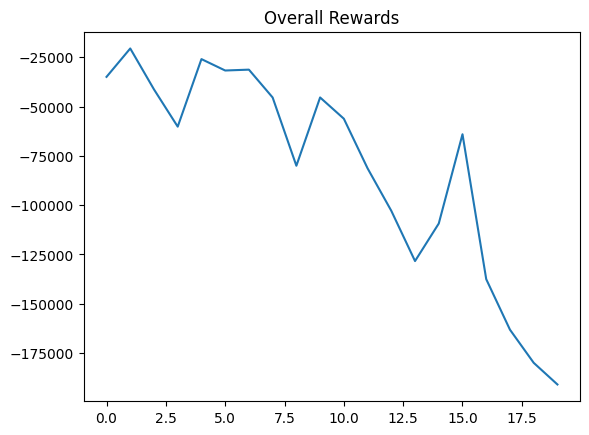

In [22]:
import matplotlib.pyplot as plt
node_feature_dim = 2
device = 'cuda' if torch.cuda.is_available() else 'cpu'
env = DockingEnv(heavy_chains, antigen_chains, featurizer, device=device)
agent = PPOAgent(
    obs_dim=node_feature_dim,
    action_dim=6,
    hidden_dim=128,
    lr_actor=1e-4,
    lr_critic=1e-4,
    continuous_action_space=True,
    device=device
)

num_episodes = 20
rewards = []
for ep in tqdm(range(num_episodes)):
    state = env.reset()
    done = False
    ep_reward = []
    while not done:
        action, logprob = agent.policy.select_action(state)
        
        # Compute state value
        batch = torch.zeros(state.x.size(0), dtype=torch.long, device=state.x.device)
        _, state_value = agent.policy.forward(state.x, state.edge_index, state.edge_attr, batch)
        state_value = state_value.squeeze().item()
        
        next_state, reward, done, _ = env.step(action.detach().cpu().numpy() if isinstance(action, torch.Tensor) else action)
        ep_reward.append(reward)
        
        # Save in buffer
        agent.buffer.states.append(state)
        agent.buffer.actions.append(action.detach().cpu().numpy() if isinstance(action, torch.Tensor) else action)
        agent.buffer.rewards.append(reward)
        agent.buffer.dones.append(done)
        agent.buffer.logprobs.append(logprob.detach().cpu().item() if isinstance(logprob, torch.Tensor) else logprob)
        agent.buffer.state_values.append(state_value)
        
        state = next_state
    ep_reward = sum(ep_reward)/len(ep_reward)
    rewards.append(ep_reward)
    agent.update_policy()
    
plt.title(f"Overall Rewards")
plt.plot(rewards)
plt.show()
